# Import packages

In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold, cross_validate, LeaveOneOut
import time
import seaborn as sns

# Writing a function for our needs:
- ~~Handle importing a single or a list of dataframes~~ Handle this with a loop that incorporates the function
- Decide whether a dataframe needs to have the zero columns taken out
- Possibly allow for PCA inside of the function? TBD
- Return results to a dataframe, write them to csv
- Allow user to specfiy notes for the runs
- Specify models used for training
- Cross validation will be on by default, too complicated to have both functionality


In [4]:
def train_test_models(file_name, models='ALL', crossval_method='kfold',
                        zero_column_delete=True, absolute_value=True, notes=None, random=True, random_drop_num=5):
    """[summary]

    Args:
        file_name ([type]): file to use for data
        models (str, optional): Model to be used for training and testing. Defaults to 'ALL'.
                                If all is selected, many different types of classifiers will
                                be used for training and testing.
        crossval_method (str, optional): Cross validation method used for model training.
                                         'kfold' and 'loo' are acceptable inputs.
                                         Defaults to 'kfold'.
        zero_column_delete (bool, optional): Gets rid of columns with all values=0. Defaults to True.
        absolute_value (bool, optional): Takes the absolute value of every datapoint. Defaults to True.
        notes ([type], optional): Description of the run. Defaults to None.
    """

    print("############################")
    print("Begining train_test function")
    print("############################")
    print(f'File the data is being pulled from: {file_name}')

    # Load in the data using pandas into a dataframe
    data_df = pd.read_csv(file_name, header=None)
    print(f'Data is of shape {data_df.shape}')

    # Delete the zero value columns if argument is provided
    if zero_column_delete:
        print('Columns with all Zeros are being removed')
        data_df = data_df.loc[:, (data_df != 0).any(axis=0)]
    
    # Get values from dataframe 
    X = data_df.iloc[:, 1:].values
    y = data_df.iloc[:, 0].values

    # Set absolute value of X if argument is provided
    if absolute_value:
        X = abs(X)
    
    # Initialize models if 'ALL' is selected
    if models == 'ALL':
        models = [AdaBoostClassifier(),
                GradientBoostingClassifier(),
                RandomForestClassifier(), 
                DecisionTreeClassifier(),
                ExtraTreesClassifier(),
                svm.SVC(C=1000, gamma='auto'),
                SGDClassifier(random_state=2021)]

    ## Check to see if model is in list or not
    elif type(models) is not list:
        print(f'{models} is not given in list format')
        raise

    # Initialize cross validation
    if crossval_method == 'kfold':
        cross_val = KFold(n_splits=10,
                          shuffle=True,
                          random_state = 42)
    elif crossval_method == 'loo':
        cross_val = LeaveOneOut()
    else:
        print('crossval_method neither kfold or loo')

    ## add random drop out
    columns_zeroed = []
    if random_drop_num:
        for x in range(random_drop_num):
            drop_col = np.random.randint(X.shape[1])
            X[:,drop_col] = 0
            columns_zeroed.append(drop_col)
    
    columns_zeroed = set(columns_zeroed)
    columns_left = X.shape[1] - len(columns_zeroed)

    # Initiailze dataframe to store results
    results_df = pd.DataFrame([], columns = ['filename',
                                                'model',
                                                'train_scores',
                                                'test_scores',
                                                'min_test',
                                                'avg_test',
                                                'max_test',
                                                'col_num_zeroed',
                                                'len_col_num_zeroed',
                                                'len_col_left',
                                                'notes',
                                                ])
    
    # Model training testing loop
    for model in models:
        print('-----------------')
        print(f'{model} being used')
        results = cross_validate(model, X, y, cv=cross_val, return_train_score=True)
        train_score = results['train_score']
        test_score = results['test_score']
        test_min = min(test_score)
        test_avg = np.mean(test_score)
        test_max = max(test_score)
        print(f'train scores: {train_score}')
        print(f'test scores: {test_score}')
        ## Create a dict to store results (makes dataframes easier)
        results_dict = {'filename': file_name,
                        'col_num_zeroed': [columns_zeroed],
                        'len_col_num_zeroed': len(columns_zeroed),
                        'len_col_left': columns_left,
                        'model': str(model),
                        'train_scores': [train_score.round(3)],
                        'test_scores': [test_score.round(3)],
                        'min_test': test_min,
                        'avg_test': test_avg,
                        'max_test': test_max,
                        'notes': notes,
                        }
        temp_df = pd.DataFrame(results_dict, index=[0])
        results_df = results_df.append(temp_df, ignore_index=True)
        del results
        del model
        time.sleep(2)
        print('---------------------------------')

    return(results_df, X)

# Test function

In [5]:
# test_file = './data/eig_centrality.csv'
# results = train_test_models(test_file)

In [6]:
# results

# Question about how absolute value affects results

In [7]:
# # Create a dataframe to store all results from all tests
# master_results = pd.DataFrame(None)

# # Raw data with negatives and zeros
# notes = 'raw data, has negatives, has zeros'
# raw_data_results = train_test_models('./data/eig_centrality.csv', zero_column_delete=False, absolute_value=False,
#                                     notes=notes)

# # Raw data with negatives and zeros taken out
# notes = 'raw data, has negatives, zeros are removed'
# noZeros_Negatives_data_results = train_test_models('./data/eig_centrality.csv', zero_column_delete=True, absolute_value=False,
#                                     notes=notes)

# # Raw data with no negatives and no zeros
# notes = 'raw data, no negatives(absolute values only), zeros are removed'
# noZeros_noNegatives_raw_data_results = train_test_models('./data/eig_centrality.csv', zero_column_delete=True, absolute_value=True,
#                                     notes=notes)

# # Elasticnet results
# notes = 'Elasticnet Used as dimensionality reduction'
# notes = 'Dimensionality reduction using elasticnet'
# elastic_net_results = train_test_models('./data/60x61.csv', zero_column_delete=False, absolute_value=False,
#                                         notes=notes)

# master_results = master_results.append(raw_data_results, ignore_index=True)
# master_results = master_results.append(noZeros_Negatives_data_results, ignore_index=True)
# master_results = master_results.append(noZeros_noNegatives_raw_data_results, ignore_index=True)
# master_results = master_results.append(elastic_net_results, ignore_index=True)


In [8]:
# master_results.head(15)

In [9]:
# master_results.to_csv('models_results.csv',index=False)

# Multiple data files
Upload a zip file containing all your data
You can use the unix command line interface through the jupyter notebook by using **"!"**

In [10]:
# unzip data folder
'''
Use the folder icon on the left side to open the running directory.
You must be connected to a run time for the directory to be shown.
before you run the following cells.

CHANGE THE BELOW FILE NAME TO YOUR ZIP FILE NAME
'''
# !unzip ./data.zip

'\nUse the folder icon on the left side to open the running directory.\nYou must be connected to a run time for the directory to be shown.\nbefore you run the following cells.\n\nCHANGE THE BELOW FILE NAME TO YOUR ZIP FILE NAME\n'

In [11]:
# use os to get files in the said directory
'''
MODIFY THE 'data_directory' VARIABLE TO THE PATH TO YOUR DATA
'''
data_directory = './variable_check' # Specify the data folder ## This is necessary ##
data_files = [] # create an empty list object to store the file paths
for x in os.listdir(data_directory):
    if x.endswith('.csv'): # get only files that are csv
        data_files.append(f'{data_directory}/{x}') # get direct path
print(data_files)

['./variable_check/eig_centrality_65.csv', './variable_check/eig_centrality_75.csv', './variable_check/eig_centrality_10.csv', './variable_check/eig_centrality_3.csv', './variable_check/eig_centrality_160.csv', './variable_check/eig_centrality_1.csv', './variable_check/eig_centrality_166.csv', './variable_check/60x61.csv', './variable_check/eig_centrality_7.csv', './variable_check/eig_centrality_24.csv', './variable_check/eig_centrality_34.csv', './variable_check/eig_centrality_85.csv', './variable_check/eig_centrality_268.csv', './variable_check/eig_centrality_122.csv', './variable_check/eig_centrality_92.csv', './variable_check/eig_centrality_108.csv', './variable_check/eig_centrality_44.csv', './variable_check/eig_centrality.csv']


In [12]:
# loop over the files to train models and get results
master_df = pd.DataFrame(None) # create a dataframe to store model training results
models = [svm.SVC(C=1000, gamma='auto')]
for data_file in data_files:
    # Run our function uisng "loo" cross validation
    # If you want kfold change the crossval_method='kfold'
    run_results, X_used = train_test_models(data_file, models='ALL', crossval_method='loo', random_drop_num=False)
    master_df = master_df.append(run_results, ignore_index=True)

############################
Begining train_test function
############################
File the data is being pulled from: ./variable_check/eig_centrality_65.csv
Data is of shape (60, 66)
Columns with all Zeros are being removed
-----------------
AdaBoostClassifier() being used
train scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test scores: [1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
---------------------------------
-----------------
GradientBoostingClassifier() being used
train scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test scores: [0. 1. 1. 0. 0. 1. 1. 0

In [13]:
# view results
master_df.head(40)

,filename,model,train_scores,test_scores,min_test,avg_test,max_test,col_num_zeroed,len_col_num_zeroed,len_col_left,notes
0,./variable_check/eig_centrality_65.csv,AdaBoostClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0,0.633333,1.0,{},0,65,None
1,./variable_check/eig_centrality_65.csv,GradientBoostingClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,0.550000,1.0,{},0,65,None
2,./variable_check/eig_centrality_65.csv,RandomForestClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0,0.683333,1.0,{},0,65,None
3,./variable_check/eig_centrality_65.csv,DecisionTreeClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,0.483333,1.0,{},0,65,None
4,./variable_check/eig_centrality_65.csv,ExtraTreesClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0,0.733333,1.0,{},0,65,None
5,./variable_check/eig_centrality_65.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.000000,1.0,{},0,65,None
6,./variable_check/eig_centrality_65.csv,SGDClassifier(random_state=2021),"[0.492, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.492, 1...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,0.833333,1.0,{},0,65,None
7,./variable_check/eig_centrality_75.csv,AdaBoostClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0,0.550000,1.0,{},0,75,None
8,./variable_check/eig_centrality_75.csv,GradientBoostingClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,0.533333,1.0,{},0,75,None
9,./variable_check/eig_centrality_75.csv,RandomForestClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,0.650000,1.0,{},0,75,None


In [17]:
# Sort values by average test value
master_df.sort_values(by=['avg_test'],axis=0, ascending=False)

,filename,model,train_scores,test_scores,min_test,avg_test,max_test,col_num_zeroed,len_col_num_zeroed,len_col_left,notes
5,./variable_check/eig_centrality_65.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.000000,1.0,{},0,65,None
54,./variable_check/60x61.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.983333,1.0,{},0,60,None
12,./variable_check/eig_centrality_75.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.983333,1.0,{},0,75,None
82,./variable_check/eig_centrality_85.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.966667,1.0,{},0,85,None
103,./variable_check/eig_centrality_92.csv,"SVC(C=1000, gamma='auto')","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.966667,1.0,{},0,92,None
...,...,...,...,...,...,...,...,...,...,...,...
86,./variable_check/eig_centrality_268.csv,RandomForestClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0.0,0.416667,1.0,{},0,268,None
87,./variable_check/eig_centrality_268.csv,DecisionTreeClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.0,0.416667,1.0,{},0,268,None
45,./variable_check/eig_centrality_166.csv,DecisionTreeClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.0,0.416667,1.0,{},0,166,None
92,./variable_check/eig_centrality_122.csv,GradientBoostingClassifier(),"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0.0,0.416667,1.0,{},0,122,None


In [18]:
# Save the results to disk
master_df.to_csv('./all_data_files_results.csv')

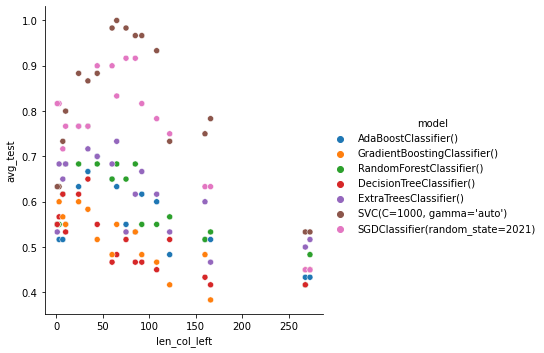

In [28]:
# plot results as number of features
# master_df.plot.scatter(x='len_col_left', y='avg_test', c='model', colormap='jet')
sns.relplot(data=master_df, x='len_col_left', y='avg_test', hue='model')